In [1]:
import os

import matplotlib.pyplot as plt
import xmltodict
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import logging

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig

from gammapy.catalog import CATALOG_REGISTRY
from gammapy.modeling.models import Models, SPECTRAL_MODEL_REGISTRY, SPATIAL_MODEL_REGISTRY
from gammapy.maps import Map

In [2]:
from asgardpy.data.dataset_3d import Dataset3DGeneration
from asgardpy.base.geom import get_source_position, generate_geom
from asgardpy.data.target import (
    set_models, 
    apply_selection_mask_to_models,
    create_gal_diffuse_skymodel, 
    create_source_skymodel, 
    read_models_from_asgardpy_config
)
from asgardpy.gammapy.interoperate_models import (
    xml_spectral_model_to_gammapy,
    xml_spatial_model_to_gammapy,
)

In [3]:
os.environ['GAMMAPY_DATA']

'/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/'

In [4]:
log = logging.getLogger("test Models from XML")

In [5]:
config_file = "../asgardpy/tests/config_test_base.yaml"

In [6]:
config = AsgardpyConfig()

In [7]:
%%time
config_main = config.read(config_file)

CPU times: user 40.6 ms, sys: 3.39 ms, total: 44 ms
Wall time: 42.3 ms


# Update path of test data

In [8]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

In [9]:
for g in config_main.general:
    print(g)

('log', LogConfig(level='info', filename='', filemode='w', format='', datefmt=''))
('outdir', PosixPath('.'))
('n_jobs', 10)
('parallel_backend', <ParallelBackendEnum.multi: 'multiprocessing'>)
('steps', [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>, <AnalysisStepEnum.datasets_1d: 'datasets-1d'>, <AnalysisStepEnum.fit: 'fit'>, <AnalysisStepEnum.flux_points: 'flux-points'>])
('overwrite', True)
('stacked_dataset', True)


# Steps mentioned in the main config file

In [10]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

# Target source information

In [11]:
for c in config_main.target:
    print(c)

('source_name', '4FGL J0534.5+2201i')
('sky_position', SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.633 deg>, lat=<Angle 22.02 deg>, radius=<Angle 0. deg>))
('use_uniform_position', True)
('models_file', PosixPath('.'))
('add_fov_bkg_model', False)
('use_catalog', CatalogConfig(name='', selection_radius=<Angle 0. deg>, exclusion_radius=<Angle 0. deg>))
('components', [SkyModelComponent(name='4FGL J0534.5+2201i', type='SkyModel', spectral=SpectralModelConfig(type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.01, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.7, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.01, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(filename=PosixPath('.'), reference='domingu

# 3D Datasets informations

In [12]:
for cc in config_main.dataset3d:
    print(cc)

('type', <ReductionTypeEnum.cube: '3d'>)
('instruments', [Dataset3DBaseConfig(name='Fermi-LAT', input_dl3=[InputDL3Config(type='lat', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'events': '*ft*.fits*', 'edisp': 'drm*.fits*', 'xml_model': 'srcmdl*.xml', 'exposure': 'bexpmap*.fits*', 'psf': 'psf*.fits*'}), InputDL3Config(type='lat-aux', input_dir=PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'), glob_pattern={'gal_diffuse': 'gll_iem_v07_cutout.fits*', 'iso_diffuse': 'iso_P8R3_SOURCE_V3_*.txt'})], input_dl4=False, dataset_info=Dataset3DInfoConfig(name='Fermi-LAT', key=['00', '01'], observation=ObservationsConfig(obs_ids=[], obs_file=PosixPath('.'), obs_time=TimeIntervalsConfig(format=<TimeFormatEnum.iso: 'iso'>, intervals=[TimeRangeConfig(start=<Time object: scale='utc' format='mjd' value=0.0>, stop=<Time object: scale='utc' format='mjd' value=0.0>)])

In [13]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


CPU times: user 1.26 ms, sys: 440 µs, total: 1.7 ms
Wall time: 1.24 ms


In [14]:
analysis

# Get XML file from a single 3D Dataset - Fermi-LAT

In [15]:
instruments_list = config_main.dataset3d.instruments
print(len(instruments_list), "number of 3D dataset information provided")

config_3d_dataset = instruments_list[0]
print(f"Instrument selected is {config_3d_dataset.name}")

key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

1 number of 3D dataset information provided
Instrument selected is Fermi-LAT
The list of different keys or modes of observations for the selected instrument are ['00', '01']


In [16]:
%%time
generate_3d_dataset = Dataset3DGeneration(
    log, config_3d_dataset, analysis.config
)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 22.6 µs


In [17]:
if len(key_names) == 0:
    key_names = [None]

In [18]:
exclusion_regions = []

In [19]:
%%time
file_list = generate_3d_dataset.read_to_objects(key_names[0])

Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.


CPU times: user 1.19 s, sys: 40.8 ms, total: 1.23 s
Wall time: 1.23 s


In [20]:
print(f"The XML file selected is {file_list['xml_file']}")
xml_file = file_list['xml_file']

The XML file selected is /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/srcmdl_00.xml


# Read into Models from XML file

In [21]:
with open(xml_file) as f:
    data = xmltodict.parse(f.read())["source_library"]["source"]

In [22]:
print("The sources for which model information is given in the XML file, along with their spectral and spatial model:")
for source in data:
    print(source["@name"], source["spectrum"]["@type"], source["spatialModel"]["@type"])

The sources for which model information is given in the XML file, along with their spectral and spatial model:
4FGL J0534.5+2201i LogParabola RadialGaussian
4FGL J0534.5+2201s PowerLaw SkyDirFunction
4FGL J0534.5+2200 PLSuperExpCutoff2 SkyDirFunction
4FGL J0526.3+2246 PowerLaw SkyDirFunction
4FGL J0544.4+2238 PowerLaw SkyDirFunction
4FGL J0521.7+2112 LogParabola SkyDirFunction
4FGL J0528.3+1817 PowerLaw SkyDirFunction
4FGL J0536.2+1733 LogParabola SkyDirFunction
4FGL J0550.9+2552c PowerLaw SkyDirFunction
4FGL J0539.0+1644 PowerLaw SkyDirFunction
4FGL J0534.2+2751 PowerLaw SkyDirFunction
4FGL J0540.3+2756e LogParabola SpatialMap
4FGL J0521.2+1637 PowerLaw SkyDirFunction
4FGL J0552.0+2656c PowerLaw SkyDirFunction
4FGL J0601.4+2320 PowerLaw SkyDirFunction
4FGL J0509.1+1943 PowerLaw SkyDirFunction
4FGL J0533.9+2838 PowerLaw SkyDirFunction
4FGL J0519.6+2744 PowerLaw SkyDirFunction
4FGL J0603.9+2159 PowerLaw SkyDirFunction
4FGL J0510.0+1800 LogParabola SkyDirFunction
4FGL J0524.5+2839 PowerL

In [23]:
print("Diffuse Isotropic Model already initialized")
print(generate_3d_dataset.diffuse_models["iso_diffuse"])

Diffuse Isotropic Model already initialized
SkyModel

  Name                      : fermi-diffuse-iso-00
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ConstantSpatialModel
  Temporal model type       : 
  Parameters:
    norm                  (frozen):      1.000                   
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         
    value                 (frozen):      1.000       1 / sr      




In [24]:
diff_gal = create_gal_diffuse_skymodel(generate_3d_dataset.diffuse_models["gal_diffuse"])
print(diff_gal)

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [25]:
aux_path = generate_3d_dataset.config_3d_dataset.input_dl3[1].input_dir
print(aux_path)

/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab


In [26]:
# Check if the Spectral Model type is properly translated
for source in data:
    source_name = source["@name"]
    if source_name not in ["IsoDiffModel", "GalDiffModel", "isodiff", "galdiff"]:
        spectrum_ = source["spectrum"]["parameter"]
        spectrum_type = source["spectrum"]["@type"].split("EblAtten::")[-1]

        if spectrum_[0]["@name"] not in ["GalDiffModel", "IsoDiffModel"]:
            if spectrum_type in ["PLSuperExpCutoff", "PLSuperExpCutoff2"]:
                spectrum_type_final = "ExpCutoffPowerLawSpectralModel"
            elif spectrum_type == "PLSuperExpCutoff4":
                spectrum_type_final = "SuperExpCutoffPowerLaw4FGLDR3SpectralModel"
            else:
                spectrum_type_final = f"{spectrum_type}SpectralModel"

            spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls(spectrum_type_final)()

            if spectrum_type == "LogParabola":
                if "EblAtten" in source["spectrum"]["@type"]:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls("PowerLawSpectralModel")()
                    ebl_atten_pl = True
                else:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls(
                        "LogParabolaSpectralModel"
                    )()
        print(spectrum_type, spectral_model.tag)

LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PLSuperExpCutoff2 ['ExpCutoffPowerLawSpectralModel', 'ecpl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
LogParabola ['LogParabolaSpectralModel', 'lp']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLaw ['PowerLawSpectralModel', 'pl']
PowerLa

In [27]:
# Check if the Spectral Model parameters are properly translated
for source in data:
    source_name = source["@name"]

    if source_name not in ["IsoDiffModel", "GalDiffModel", "isodiff", "galdiff"]:
        print(f"\n{source_name}\n")
        spectrum_ = source["spectrum"]["parameter"]
        spectrum_type = source["spectrum"]["@type"].split("EblAtten::")[-1]

        print(spectrum_type)
        for p in spectrum_:
            print(f'Name: {p["@name"]:12s} \tScale: {float(p["@scale"]):6e} \tFrozen: {p["@free"]}')
            print(
                f'Value: {(float(p["@value"]) * float(p["@scale"])):.6e}' + 
                f' \tMin: {(float(p["@min"]) * float(p["@scale"])):.6e}' + 
                f' \tMax: {(float(p["@max"]) * float(p["@scale"])):.6e}'
            )

        if spectrum_[0]["@name"] not in ["GalDiffModel", "IsoDiffModel"]:
            if spectrum_type in ["PLSuperExpCutoff", "PLSuperExpCutoff2"]:
                spectrum_type_final = "ExpCutoffPowerLawSpectralModel"
            elif spectrum_type == "PLSuperExpCutoff4":
                spectrum_type_final = "SuperExpCutoffPowerLaw4FGLDR3SpectralModel"
            else:
                spectrum_type_final = f"{spectrum_type}SpectralModel"

            spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls(spectrum_type_final)()

            if spectrum_type == "LogParabola":
                if "EblAtten" in source["spectrum"]["@type"]:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls("PowerLawSpectralModel")()
                    ebl_atten_pl = True
                else:
                    spectral_model = SPECTRAL_MODEL_REGISTRY.get_cls(
                        "LogParabolaSpectralModel"
                    )()
        # Read the parameter values from XML file to create SpectralModel
        params_list = xml_spectral_model_to_gammapy(
            spectrum_,
            spectrum_type,
        )
        print("\n", spectral_model.tag)
        for p in params_list:
            print(f"Name: {p.name:12s} \tScale: {p.scale} \t\tFrozen:{p.frozen}")
            print(f"Value: {p.value:.6e} \tMin: {p.min:.6e} \tMax: {p.max:.6e}")



4FGL J0534.5+2201i

LogParabola
Name: Eb           	Scale: 1.000000e+03 	Frozen: 0
Value: 1.000000e+04 	Min: 1.000000e+02 	Max: 1.000000e+05
Name: alpha        	Scale: 1.000000e+00 	Frozen: 0
Value: 1.750000e+00 	Min: 0.000000e+00 	Max: 5.000000e+00
Name: beta         	Scale: 1.000000e-01 	Frozen: 0
Value: 8.000000e-02 	Min: -5.000000e-01 	Max: 1.000000e+00
Name: norm         	Scale: 1.000000e-13 	Frozen: 0
Value: 5.500000e-13 	Min: 0.000000e+00 	Max: 1.000000e-11

 ['LogParabolaSpectralModel', 'lp']
Name: reference    	Scale: 1.0 		Frozen:True
Value: 1.000000e-02 	Min: 1.000000e-04 	Max: 1.000000e-01
Name: alpha        	Scale: 1.0 		Frozen:True
Value: 1.750000e+00 	Min: 0.000000e+00 	Max: 5.000000e+00
Name: beta         	Scale: 1.0 		Frozen:True
Value: 8.000000e-02 	Min: -5.000000e-01 	Max: 1.000000e+00
Name: amplitude    	Scale: 1.0 		Frozen:True
Value: 5.500000e-07 	Min: 0.000000e+00 	Max: 1.000000e-05

4FGL J0534.5+2201s

PowerLaw
Name: Index        	Scale: -1.000000e+00 	Frozen: 

# Get the list of source models

In [28]:
list_sources = []
is_target_source = False

for source in data:
    source_name = source["@name"]
    if source_name not in ["IsoDiffModel", "GalDiffModel", "isodiff", "galdiff"]:
        source, is_target_source = create_source_skymodel(
            analysis.config.target, source, aux_path
        )

        if is_target_source:
            list_sources.insert(0, source)
        else:
            list_sources.append(source)

In [29]:
list_sources.append(generate_3d_dataset.diffuse_models["iso_diffuse"])

In [30]:
print(len(list_sources))

54


In [31]:
for m in list_sources:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         


Sky

In [32]:
target_pos = Models(list_sources)[config_main.target.source_name].spatial_model.position.icrs
for m in list_sources:
    print("\n", m.name)
    if m.spatial_model.position:
        print(f"Separation from Target source is {target_pos.separation(m.spatial_model.position.icrs).deg:.3f} deg")
    if m.spectral_model.tag[1] == "compound":
        print(m.spectral_model.model1.tag[0])
    else:
        print(m.spectral_model.tag[0])
    for p in m.spectral_model.parameters:
        print(p.name, p._is_norm)


 4FGL J0534.5+2201i
Separation from Target source is 0.000 deg
LogParabolaSpectralModel
amplitude True
reference False
alpha False
beta False
alpha_norm False
redshift False

 4FGL J0534.5+2201s
Separation from Target source is 0.000 deg
PowerLawSpectralModel
index False
amplitude True
reference False

 4FGL J0534.5+2200
Separation from Target source is 0.006 deg
ExpCutoffPowerLawSpectralModel
index False
amplitude True
reference False
lambda_ False
alpha False

 4FGL J0526.3+2246
Separation from Target source is 2.034 deg
PowerLawSpectralModel
index False
amplitude True
reference False

 4FGL J0544.4+2238
Separation from Target source is 2.373 deg
PowerLawSpectralModel
index False
amplitude True
reference False

 4FGL J0521.7+2112
Separation from Target source is 3.072 deg
LogParabolaSpectralModel
amplitude True
reference False
alpha False
beta False

 4FGL J0528.3+1817
Separation from Target source is 3.996 deg
PowerLawSpectralModel
index False
amplitude True
reference False

 4FGL 

(1e-13, 1e-08)

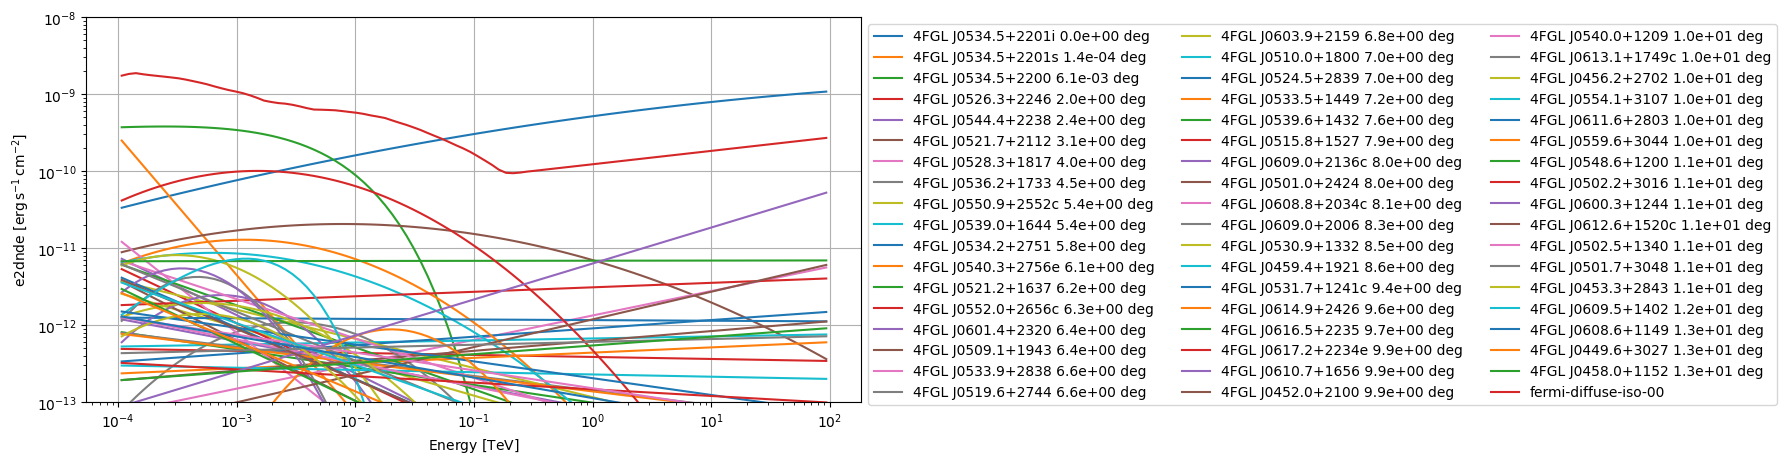

In [33]:
plt.figure(figsize=(10,5))
en_b = [1e-4, 1e2] * u.TeV
for m in list_sources:
    if m.spatial_model.position:
        label_ = f"{m.name} {target_pos.separation(m.spatial_model.position.icrs).deg:.1e} deg"
    else:
        label_ = m.name
    m.spectral_model.plot(energy_bounds=en_b, sed_type="e2dnde", label=label_)

plt.grid()
plt.legend(bbox_to_anchor=(1,1), ncols=int(np.sqrt(len(list_sources))/2))
plt.ylim(1e-13, 1e-8)

# Spatial Models

In [34]:
for source in data:
    print(source["@name"])
    xml_spatial_model = source["spatialModel"]
    spatial_pars = xml_spatial_model["parameter"]

    if xml_spatial_model["@type"] == "SkyDirFunction":
        for par_ in spatial_pars:
            print(par_)
            if par_["@name"] == "RA":
                lon_0 = f"{par_['@value']} deg"
            if par_["@name"] == "DEC":
                lat_0 = f"{par_['@value']} deg"
        fk5_frame = SkyCoord(
            lon_0,
            lat_0,
            frame="fk5",
        )
        gal_frame = fk5_frame.transform_to("galactic")
        spatial_model = SPATIAL_MODEL_REGISTRY.get_cls("PointSpatialModel")().from_position(
            gal_frame
        )

    elif xml_spatial_model["@type"] == "SpatialMap":
        file_name = xml_spatial_model["@file"].split("/")[-1]
        file_path = aux_path / f"Templates/{file_name}"

        spatial_map = Map.read(file_path)
        spatial_map = spatial_map.copy(unit="sr^-1")

        spatial_model = SPATIAL_MODEL_REGISTRY.get_cls("TemplateSpatialModel")(
            spatial_map, filename=file_path
        )

    elif xml_spatial_model["@type"] == "RadialGaussian":
        for par_ in spatial_pars:
            print(par_)
            if par_["@name"] == "RA":
                lon_0 = f"{par_['@value']} deg"
            if par_["@name"] == "DEC":
                lat_0 = f"{par_['@value']} deg"
            if par_["@name"] == "Sigma":
                sigma = f"{par_['@value']} deg"
        fk5_frame_ = SkyCoord(
            lon_0,
            lat_0,
            frame="fk5",
        )
        print(fk5_frame_)
        gal_frame = fk5_frame_.transform_to("galactic")

        spatial_model = SPATIAL_MODEL_REGISTRY.get_cls("GaussianSpatialModel")(
            lon_0=gal_frame.l, lat_0=gal_frame.b, sigma=sigma, frame="galactic"
        )

    print(spatial_model.position)


4FGL J0534.5+2201i
{'@free': '0', '@max': '90.0', '@min': '-90.0', '@name': 'DEC', '@scale': '1.0', '@value': '22.02'}
{'@free': '0', '@max': '360.0', '@min': '0.0', '@name': 'RA', '@scale': '1.0', '@value': '83.633'}
{'@free': '0', '@max': '10.0', '@min': '0.0', '@name': 'Sigma', '@scale': '1.0', '@value': '0.02'}
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (83.633, 22.02)>
<SkyCoord (Galactic): (l, b) in deg
    (184.55273876, -5.78148086)>
4FGL J0534.5+2201s
{'@free': '0', '@max': '90.0', '@min': '-90.0', '@name': 'DEC', '@scale': '1.0', '@value': '22.0199'}
{'@free': '0', '@max': '360.0', '@min': '-360.0', '@name': 'RA', '@scale': '1.0', '@value': '83.6331'}
<SkyCoord (Galactic): (l, b) in deg
    (184.55287354, -5.78145609)>
4FGL J0534.5+2200
{'@free': '0', '@max': '90.0', '@min': '-90.0', '@name': 'DEC', '@scale': '1.0', '@value': '22.0149'}
{'@free': '0', '@max': '360.0', '@min': '-360.0', '@name': 'RA', '@scale': '1.0', '@value': '83.6367'}
<SkyCoord (Galactic): (l

In [35]:
for m in list_sources:
    print("\n", m.name, m.spatial_model.tag)
    print(m.spatial_model, m.spatial_model.evaluation_radius)


 4FGL J0534.5+2201i ['GaussianSpatialModel', 'gauss']
GaussianSpatialModel

  type   name    value    unit   error      min        max    frozen is_norm link
------- ----- ----------- ---- --------- ---------- --------- ------ ------- ----
spatial lon_0  1.8455e+02  deg 0.000e+00        nan       nan   True   False     
spatial lat_0 -5.7815e+00  deg 0.000e+00 -9.000e+01 9.000e+01   True   False     
spatial sigma  2.0000e-02  deg 0.000e+00  0.000e+00       nan   True   False     
spatial     e  0.0000e+00      0.000e+00  0.000e+00 1.000e+00   True   False     
spatial   phi  0.0000e+00  deg 0.000e+00        nan       nan   True   False      0.1 deg

 4FGL J0534.5+2201s ['PointSpatialModel', 'point']
PointSpatialModel

  type   name    value    unit   error      min        max    frozen is_norm link
------- ----- ----------- ---- --------- ---------- --------- ------ ------- ----
spatial lon_0  3.2211e+00  rad 0.000e+00        nan       nan   True   False     
spatial lat_0 -1.0091e-0

4FGL J0534.5+2201i GaussianSpatialModel

  type   name    value    unit   error      min        max    frozen is_norm link
------- ----- ----------- ---- --------- ---------- --------- ------ ------- ----
spatial lon_0  1.8455e+02  deg 0.000e+00        nan       nan   True   False     
spatial lat_0 -5.7815e+00  deg 0.000e+00 -9.000e+01 9.000e+01   True   False     
spatial sigma  2.0000e-02  deg 0.000e+00  0.000e+00       nan   True   False     
spatial     e  0.0000e+00      0.000e+00  0.000e+00 1.000e+00   True   False     
spatial   phi  0.0000e+00  deg 0.000e+00        nan       nan   True   False     


<WCSAxes: >

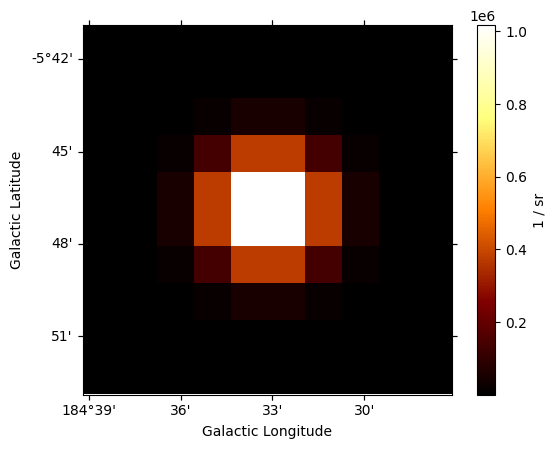

In [36]:
idx = 0
print(list_sources[idx].name, list_sources[idx].spatial_model)
test_ = list_sources[idx].spatial_model
test_.plot(add_cbar=True)

# Reading models from Config file

In [37]:
model = read_models_from_asgardpy_config(analysis.config.target)

In [38]:
print(model[0].spectral_model)

CompoundSpectralModel
    Component 1 : LogParabolaSpectralModel

  type      name     value         unit        error      min       max    frozen is_norm link
-------- --------- ---------- -------------- --------- --------- --------- ------ ------- ----
spectral amplitude 1.0000e-06 TeV-1 s-1 cm-2 1.500e-07 1.000e-13 1.000e-02  False    True     
spectral reference 1.0000e-02            TeV 0.000e+00 1.000e-04 1.000e+02   True   False     
spectral     alpha 1.7000e+00                1.000e-01 5.000e-01 5.000e+00  False   False     
spectral      beta 1.0000e-02                1.000e-03 1.000e-06 1.000e+00  False   False     
    Component 2 : EBLAbsorptionNormSpectralModel

  type      name      value    unit   error   min max frozen is_norm link
-------- ---------- ---------- ---- --------- --- --- ------ ------- ----
spectral alpha_norm 1.0000e+00      0.000e+00 nan nan   True   False     
spectral   redshift 0.0000e+00      0.000e+00 nan nan   True   False     
    Operator : mul

In [39]:
print(model[0].spatial_model)

None


# Apply selection mask to list of models

In [40]:
list_sources = apply_selection_mask_to_models(
    list_sources,
    target_source=analysis.config.target.source_name,
    roi_radius=analysis.config.target.roi_selection.roi_radius,
    free_sources=analysis.config.target.roi_selection.free_sources
)

In [41]:
for m in list_sources:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.010       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.010   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         


Sky

In [42]:
print(len(list_sources))

54


In [43]:
print(len(list_sources.parameters.free_parameters))

8


# Get models from Catalog

In [44]:
base_geom = generate_geom(
    tag="3d",
    geom_config=analysis.config.dataset3d.instruments[0].dataset_info.geom,
    center_pos=get_source_position(analysis.config.target.sky_position)
)

In [45]:
analysis.config.target.use_catalog.selection_radius = 0.2 * u.deg
analysis.config.target.use_catalog.name = "4fgl"
list_sources = []

In [46]:
%%time
catalog = CATALOG_REGISTRY.get_cls(analysis.config.target.use_catalog.name)()
print(len(catalog.positions))

inside_geom = base_geom.to_image().contains(catalog.positions)

idx_list = np.nonzero(inside_geom)[0]
print(len(idx_list))

for i in idx_list:
    list_sources.append(catalog[i].sky_model())


6659
1593


/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/catalog/fermi.py:445: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/catalog/fermi.py:445: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/catalog/fermi.py:445: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/catalog/fermi.py:445: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/p

CPU times: user 30 s, sys: 229 ms, total: 30.3 s
Wall time: 30.2 s


/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/catalog/fermi.py:445: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),


In [47]:
for m_ in list_sources:
    print(m_.name)

4FGL J0003.6+3059
4FGL J0008.9+2509
4FGL J0009.9+2810
4FGL J0013.0+3355
4FGL J0013.6+4051
4FGL J0014.9+3212
4FGL J0015.2+3537
4FGL J0015.9+2440
4FGL J0018.4+2946
4FGL J0018.8+2611
4FGL J0019.6+2022
4FGL J0023.7+4457
4FGL J0024.1+2402
4FGL J0024.4+4647
4FGL J0026.2+3926
4FGL J0028.5+2001
4FGL J0028.9+3553
4FGL J0029.4+2051
4FGL J0033.9+3858
4FGL J0035.2+1514
4FGL J0036.8+1431
4FGL J0036.9+1832
4FGL J0037.6+3653
4FGL J0037.8+1239
4FGL J0037.9+2612
4FGL J0039.1+4330
4FGL J0039.7+4203
4FGL J0040.3+4050
4FGL J0040.9+3203
4FGL J0041.4+3800
4FGL J0042.0+3640
4FGL J0042.2+2319
4FGL J0042.3+3509
4FGL J0043.2+4114
4FGL J0043.6+2223
4FGL J0043.8+3425
4FGL J0044.9+4553
4FGL J0045.3+2128
4FGL J0045.7+1217
4FGL J0046.9+0705
4FGL J0047.0+5657
4FGL J0047.9+3947
4FGL J0047.9+5448
4FGL J0047.9+2233
4FGL J0049.0+2252
4FGL J0049.1+4223
4FGL J0049.7+0237
4FGL J0055.7+4507
4FGL J0056.8+1626
4FGL J0057.0+4101
4FGL J0057.3+2216
4FGL J0057.7+3023
4FGL J0058.3+1723
4FGL J0058.4+3315
4FGL J0059.2+0006
4FGL J0059

In [48]:
for m_ in list_sources:
    print(m_)

SkyModel

  Name                      : 4FGL J0003.6+3059
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.20e-13   +/- 3.9e-14 1 / (MeV s cm2)
    reference             (frozen):   1348.310       MeV         
    alpha                         :      1.724   +/-    0.23             
    beta                          :      0.665   +/-    0.23             
    lon_0                         :      0.905   +/-    0.03 deg         
    lat_0                         :     30.990   +/-    0.03 deg         


SkyModel

  Name                      : 4FGL J0008.9+2509
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.886   +/-    0.16             
    am